In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import time
import sklearn
import warnings
import pickle

warnings.filterwarnings(action='ignore', category=FutureWarning)

pd.__version__, sklearn.__version__

('2.1.1', '1.3.1')

In [2]:
SCRATCH_DIR = "/scratch/siads696f23_class_root/siads696f23_class/psollars"

# For local dev
SCRATCH_DIR = "./../data"

In [3]:
start_time = time.time()
all_features_2019 = pd.read_parquet(f"{SCRATCH_DIR}/all_features_2019.parquet")
all_features_2019 = all_features_2019[
    all_features_2019["Cancelled"].eq(0) & all_features_2019["Diverted"].eq(0)
]
end_time = time.time()


print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Elapsed time: 74.1707 seconds


In [4]:
list(all_features_2019.columns)

['Year',
 'Quarter',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'FlightDate',
 'Reporting_Airline',
 'Tail_Number',
 'Flight_Number_Reporting_Airline',
 'OriginCityMarketID',
 'Origin',
 'DestCityMarketID',
 'Dest',
 'CRSDepTime',
 'DepTime',
 'DepDelay',
 'DepDelayMinutes',
 'DepDel15',
 'DepartureDelayGroups',
 'DepTimeBlk',
 'TaxiOut',
 'WheelsOff',
 'WheelsOn',
 'TaxiIn',
 'CRSArrTime',
 'ArrTime',
 'ArrDelay',
 'ArrDelayMinutes',
 'ArrDel15',
 'ArrivalDelayGroups',
 'ArrTimeBlk',
 'Cancelled',
 'CancellationCode',
 'Diverted',
 'CRSElapsedTime',
 'ActualElapsedTime',
 'AirTime',
 'Flights',
 'Distance',
 'DistanceGroup',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay',
 'DivAirportLandings',
 'N-NUMBER',
 'SERIAL NUMBER',
 'MFR MDL CODE',
 'ENG MFR MDL',
 'YEAR MFR',
 'TYPE REGISTRANT',
 'NAME',
 'STREET',
 'STREET2',
 'CITY',
 'STATE',
 'ZIP CODE',
 'REGION',
 'COUNTY',
 'COUNTRY',
 'LAST ACTION DATE',
 'CERT ISSUE DATE',
 'CERTIFICATION',
 'TYP

In [5]:
# Blank
# N - Normal
# U - Utility
# A - Acrobatic
# T - Transport
# G - Glider
# B - Balloon
# C - Commuter

all_features_2019.value_counts("CERTIFICATION")

CERTIFICATION
1T            7189833
               138370
1               12860
1N              11061
41              10720
1A               4028
410              2957
40               2357
4103             1475
84               1405
41               1042
42                839
314               323
1NU               117
1C                 74
1NAG               71
314                71
Name: count, dtype: int64

In [6]:
# 0 - None
# 1 - Reciprocating
# 2 - Turbo-prop
# 3 - Turbo-shaft
# 4 - Turbo-jet
# 5 - Turbo-fan
# 6 - Ramjet
# 7 - 2 Cycle
# 8 - 4 Cycle
# 9 – Unknown
# 10 – Electric

all_features_2019[all_features_2019["CERTIFICATION"].str.strip().eq("1T")].value_counts("TYPE ENGINE")

TYPE ENGINE
5    6827781
4     362052
Name: count, dtype: int64

In [7]:
# R - Registration pending
# V - Valid Registration
# 5 - Reserved N-Number
# 7 - Sale reported
# 24 - Third Notice for ReRegistration/Renewal
# 25 - First Notice for Registration Renewal
# 26 - Second Notice for Registration Renewal
# 27 - Registration Expired
# 28 - Third Notice for Registration Renewal

all_features_2019.value_counts("STATUS CODE")

STATUS CODE
V     7331181
25      31460
26       4995
7        3275
28       3200
27       1479
5        1301
R         641
24         71
Name: count, dtype: int64

In [8]:
# 1 - Glider
# 2 - Balloon
# 3 - Blimp/Dirigible
# 4 - Fixed wing single engine
# 5 - Fixed wing multi engine
# 6 - Rotorcraft
# 7 - Weight-shift-control
# 8 - Powered Parachute

all_features_2019[all_features_2019["CERTIFICATION"].str.strip().eq("1T")].value_counts("TYPE")

TYPE
5     6457941
4      536529
        22528
2         734
Name: count, dtype: int64

In [9]:
# 1 - Individual
# 3 - Corporation
# 5 – Government
# 7 - LLC

all_features_2019[all_features_2019["CERTIFICATION"].str.strip().eq("1T")].value_counts("TYPE REGISTRANT")

TYPE REGISTRANT
3    6980708
7     187764
1       6689
5        862
Name: count, dtype: int64

In [10]:
# 0 – Type Certificated
# 1 – Not Type Certificated

all_features_2019[all_features_2019["CERTIFICATION"].str.strip().eq("1T")].value_counts("BUILD-CERT-IND")
# all_features_2019.value_counts("BUILD-CERT-IND")

BUILD-CERT-IND
0.0    7173707
1.0      16126
Name: count, dtype: int64

In [11]:
# Feature selection from "feature_selection_2019_UA-for-real.ipynb"

num_cols = [
    "Quarter",
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime",
    "CRSArrTime",
    "CRSElapsedTime",
    "Distance",
    "DistanceGroup",
    "YEAR MFR",
    "HORSEPOWER",
    "THRUST",
    "NO-SEATS",
    "Origin_LATITUDE",
    "Origin_LONGITUDE",
    "Dest_LATITUDE",
    "Dest_LONGITUDE",
]

cat_cols = [
    # # Remove based on the intuition that a particular day may have extremely bad weather causing many delays,
    # this guarantees overfitting to the data since this day will never happen again, it doesn't reveal a trend.
    #     "FlightDate",
    "Reporting_Airline",  # we need this to filter out the dataset later
    "Tail_Number",
    "Origin",
    "Dest",
    # "DestCityMarketID", # This is a duplication of origin and dest, which we may filter out anyway later
    # "N-NUMBER",  # Duplication of Tail_Number, we only need a single way to identify the aircraft
    # "MFR MDL CODE", # This is a joining column, duplicate of aircraft manufacturer
    # "ENG MFR MDL", # Code for engine model
    "TYPE REGISTRANT", # Corporations and LLCs
    "NAME",
    "CERTIFICATION", 
    "TYPE ENGINE",
    "STATUS CODE",
    # "MODE S CODE", These identify the aircraft uniquely, we can use tail number
    # "MODE S CODE HEX",
    # "CODE", # Duplicate of the engine model
    "MFR", # Engine manufacturer, condense this
    "MODEL", # Engine model
    "TYPE", # 5 - Fixed wing multi engine
    # "CODE_aircraft", Duplicate of the aircraft manufacturer
    "MFR_aircraft",
    "MODEL_aircraft",
    "TYPE-ENG",
    "BUILD-CERT-IND", # 0 only, we don't care about kit built aircraft
    # "faa_registration_origin", # Tracking column, may be related to registration status
    "Origin_DISPLAY_AIRPORT_NAME",
    "Origin_DISPLAY_AIRPORT_CITY_NAME_FULL",
    "Dest_DISPLAY_AIRPORT_NAME",
    "Dest_DISPLAY_AIRPORT_CITY_NAME_FULL",
]

In [12]:
all_features_2019.value_counts(
    [
        "TYPE REGISTRANT", # 7 or 3
        # "CERTIFICATION", # 1T, standard transportation, or other
        "TYPE ENGINE",
        "STATUS CODE", # V or other
        "TYPE", # 4 or 5
        "TYPE-ENG",  # 4 or 5
        "BUILD-CERT-IND" # 0 only
    ]
)

TYPE REGISTRANT  TYPE ENGINE  STATUS CODE  TYPE  TYPE-ENG  BUILD-CERT-IND
3                5            V            5     5.0       0.0               6118201
                                           4     5.0       0.0                365882
                 4            V            5     4.0       0.0                157349
                                           4     4.0       0.0                153021
7                5            V            5     5.0       0.0                151467
3                5            V                  5.0       0.0                 20404
                                           5     5.0       1.0                 16283
                              25           5     5.0       0.0                 12223
                                           4     5.0       0.0                 10203
7                5            V            4     5.0       0.0                  8410
3                4            25           4     4.0       0.0              

In [13]:
delay_cols = [
    "DepDel15",
    "ArrDel15",
    "CarrierDelay",
    "WeatherDelay",
    "NASDelay",
    "SecurityDelay",
    "LateAircraftDelay",
]

# Add delay columns so we can filter later
consolidated_df = all_features_2019[num_cols + cat_cols + delay_cols].copy()

# Identify problematic columns
# for col in consolidated_df.columns:
#     try:
#         consolidated_df[col].astype(float)
#     except ValueError:
#         print(f"Column {col} contains non-convertible values.")

cols_to_convert = [
    "YEAR MFR",
    "TYPE REGISTRANT",
    "TYPE",
    "TYPE-ENG",
    "BUILD-CERT-IND",
]

for col in cols_to_convert:
    try:
        consolidated_df[col] = pd.to_numeric(
            consolidated_df[col].str.strip(), errors="coerce"
        )
    except:
        print(col, "isn't a string")
        consolidated_df[col] = consolidated_df[col].astype("float")

# Clean up some of the weird, non-commercial aircraft registrations
consolidated_df = consolidated_df[
    (  # 7 or 3
        consolidated_df["TYPE REGISTRANT"].eq(7)
        | consolidated_df["TYPE REGISTRANT"].eq(3)
    )
    & (  # 4 or 5
        consolidated_df["TYPE"].eq(4) | consolidated_df["TYPE"].eq(5)
    )  # 4 or 5
    & (consolidated_df["TYPE-ENG"].eq(4) | consolidated_df["TYPE-ENG"].eq(5))
    & consolidated_df["BUILD-CERT-IND"].eq(0)  # 0 only
]

print(consolidated_df.value_counts("TYPE REGISTRANT"))

# 7512680 rows × 44 columns
consolidated_df

TYPE-ENG isn't a string
BUILD-CERT-IND isn't a string
TYPE REGISTRANT
3.0    6831815
7.0     165488
Name: count, dtype: int64


,Quarter,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,CRSElapsedTime,Distance,DistanceGroup,YEAR MFR,...,Origin_DISPLAY_AIRPORT_CITY_NAME_FULL,Dest_DISPLAY_AIRPORT_NAME,Dest_DISPLAY_AIRPORT_CITY_NAME_FULL,DepDel15,ArrDel15,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
24733033,1,1,4,5,1400,1510,70,190,1,2003.0,...,"San Luis Obispo, CA",San Francisco International,"San Francisco, CA",0,0,0,0,0,0,0
24733034,1,1,4,5,0935,1118,103,438,2,2002.0,...,"Houston, TX",Northwest Arkansas National,"Fayetteville, AR",0,0,0,0,0,0,0
24733035,1,1,4,5,0643,0855,132,513,3,2002.0,...,"Springfield, MO",George Bush Intercontinental/Houston,"Houston, TX",0,0,0,0,0,0,0
24733036,1,1,4,5,1335,1433,118,576,3,2002.0,...,"Williston, ND",Denver International,"Denver, CO",0,0,0,0,0,0,0
24733037,1,1,4,5,0836,1040,184,896,4,2014.0,...,"Milwaukee, WI",Denver International,"Denver, CO",0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32288695,4,12,1,7,0600,0802,122,762,4,2018.0,...,"Atlanta, GA",LaGuardia,"New York, NY",0,0,0,0,0,0,0
32288696,4,12,1,7,1209,1438,209,1310,6,1999.0,...,"Orlando, FL",Minneapolis-St Paul International,"Minneapolis, MN",1,1,0,0,0,0,23
32288697,4,12,1,7,0650,1110,200,1310,6,1999.0,...,"Minneapolis, MN",Orlando International,"Orlando, FL",0,1,0,0,36,0,0
32288698,4,12,1,7,1639,1932,293,1851,8,2000.0,...,"Washington, DC",Salt Lake City International,"Salt Lake City, UT",0,0,0,0,0,0,0


In [14]:
# Checkpoint

consolidated_df.to_parquet(f"{SCRATCH_DIR}/consolidated_features_2019.parquet")

consolidated_df = pd.read_parquet(f"{SCRATCH_DIR}/consolidated_features_2019.parquet")

In [88]:
num_cols = [
    "Quarter",
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime",
    "CRSArrTime",
    "CRSElapsedTime",
    "Distance",
    "DistanceGroup",
    "YEAR MFR",
    "HORSEPOWER",
    "THRUST",
    "NO-SEATS",
    "Origin_LATITUDE",
    "Origin_LONGITUDE",
    "Dest_LATITUDE",
    "Dest_LONGITUDE",
]

cat_cols = [
    "Reporting_Airline",
    "Tail_Number",
    "Origin",
    "Dest",
    "TYPE REGISTRANT",
    "NAME",
    "CERTIFICATION",
    "TYPE ENGINE",
    "STATUS CODE",
    "MFR",
    "MODEL",
    "TYPE",
    "MFR_aircraft",
    "MODEL_aircraft",
    "TYPE-ENG",
    # "BUILD-CERT-IND", This is only "0", we can drop it
    # 
    # Labels only, duplicates of the airport coordinates, also Origin/Dest
    # "Origin_DISPLAY_AIRPORT_NAME",
    # "Origin_DISPLAY_AIRPORT_CITY_NAME_FULL",
    # "Dest_DISPLAY_AIRPORT_NAME",
    # "Dest_DISPLAY_AIRPORT_CITY_NAME_FULL",
    #
    # Only concerned with weather delays for this round
    # "DepDel15",
    # "ArrDel15",
    # "CarrierDelay",
    "WeatherDelay",
    # "NASDelay",
    # "SecurityDelay",
    # "LateAircraftDelay",
]

list(consolidated_df.columns)

['Quarter',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'CRSDepTime',
 'CRSArrTime',
 'CRSElapsedTime',
 'Distance',
 'DistanceGroup',
 'YEAR MFR',
 'HORSEPOWER',
 'THRUST',
 'NO-SEATS',
 'Origin_LATITUDE',
 'Origin_LONGITUDE',
 'Dest_LATITUDE',
 'Dest_LONGITUDE',
 'Reporting_Airline',
 'Tail_Number',
 'Origin',
 'Dest',
 'TYPE REGISTRANT',
 'NAME',
 'CERTIFICATION',
 'TYPE ENGINE',
 'STATUS CODE',
 'MFR',
 'MODEL',
 'TYPE',
 'MFR_aircraft',
 'MODEL_aircraft',
 'TYPE-ENG',
 'BUILD-CERT-IND',
 'Origin_DISPLAY_AIRPORT_NAME',
 'Origin_DISPLAY_AIRPORT_CITY_NAME_FULL',
 'Dest_DISPLAY_AIRPORT_NAME',
 'Dest_DISPLAY_AIRPORT_CITY_NAME_FULL',
 'DepDel15',
 'ArrDel15',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay']

In [89]:
weather_df = consolidated_df[num_cols + cat_cols].copy()

weather_df.head()

,Quarter,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,CRSElapsedTime,Distance,DistanceGroup,YEAR MFR,...,CERTIFICATION,TYPE ENGINE,STATUS CODE,MFR,MODEL,TYPE,MFR_aircraft,MODEL_aircraft,TYPE-ENG,WeatherDelay
24733033,1,1,4,5,1400,1510,70,190,1,2003.0,...,1T,5,V,GE,CF34 SERIES,5.0,BOMBARDIER INC,CL-600-2B19,5.0,0
24733034,1,1,4,5,0935,1118,103,438,2,2002.0,...,1T,5,V,GE,CF34 SERIES,5.0,BOMBARDIER INC,CL-600-2B19,5.0,0
24733035,1,1,4,5,0643,0855,132,513,3,2002.0,...,1T,5,V,GE,CF34 SERIES,5.0,BOMBARDIER INC,CL-600-2B19,5.0,0
24733036,1,1,4,5,1335,1433,118,576,3,2002.0,...,1T,5,V,GE,CF34 SERIES,5.0,BOMBARDIER INC,CL-600-2B19,5.0,0
24733037,1,1,4,5,0836,1040,184,896,4,2014.0,...,1T,5,V,GE,CF34-8E5,5.0,EMBRAER S A,ERJ 170-200 LR,5.0,0


In [90]:
weather_df[
    [
        "TYPE REGISTRANT",  # 7 or 3
        # "NAME", # correlated to "Reporting_Airline"
        "CERTIFICATION",  # condense this: (1T, other)
        "TYPE ENGINE",  # 4 or 5
        "STATUS CODE",  # condense this: (V, other)
        "MFR",  # condense this: (GE, CFM INTL, IAE, ROLLS-ROYCE, P & W, other)
        "MODEL",
        "TYPE",  # 4 or 5
        "MFR_aircraft",  # condense this: (BOEING, AIRBUS, BOMBARDIER INC, EMBRAER, MCDONNELL DOUGLAS, other)
        "MODEL_aircraft",
        "TYPE-ENG",  # 4 or 5
    ]
]

,TYPE REGISTRANT,CERTIFICATION,TYPE ENGINE,STATUS CODE,MFR,MODEL,TYPE,MFR_aircraft,MODEL_aircraft,TYPE-ENG
24733033,3.0,1T,5,V,GE,CF34 SERIES,5.0,BOMBARDIER INC,CL-600-2B19,5.0
24733034,3.0,1T,5,V,GE,CF34 SERIES,5.0,BOMBARDIER INC,CL-600-2B19,5.0
24733035,3.0,1T,5,V,GE,CF34 SERIES,5.0,BOMBARDIER INC,CL-600-2B19,5.0
24733036,3.0,1T,5,V,GE,CF34 SERIES,5.0,BOMBARDIER INC,CL-600-2B19,5.0
24733037,3.0,1T,5,V,GE,CF34-8E5,5.0,EMBRAER S A,ERJ 170-200 LR,5.0
...,...,...,...,...,...,...,...,...,...,...
32288695,3.0,1T,5,V,CFM INTL,CFM56-5B3/3,5.0,AIRBUS,A321-211,5.0
32288696,3.0,1T,5,V,P & W,PW2037,5.0,BOEING,757-232,5.0
32288697,3.0,1T,5,V,P & W,PW2037,5.0,BOEING,757-232,5.0
32288698,3.0,1T,5,V,P & W,PW2037,5.0,BOEING,757-232,5.0


In [91]:
# BOEING                            2831659
# BOMBARDIER INC                    1262314
# AIRBUS                            1109980
# EMBRAER                            545175
# AIRBUS INDUSTRIE                   544195
# EMBRAER S A                        502448
# MCDONNELL DOUGLAS AIRCRAFT CO      103413
# EMBRAER-EMPRESA BRASILEIRA DE       83212
# MCDONNELL DOUGLAS                   64522
# AIRBUS SAS                          35971
# MCDONNELL DOUGLAS CORPORATION       25896
# C SERIES AIRCRAFT LTD PTNRSP         9258
# AIRBUS CANADA LTD PTNRSP             6573
# CANADAIR                             1948
# GULFSTREAM AEROSPACE CORP             229
# PILATUS AIRCRAFT LTD                   76
# DASSAULT                               75
# GULFSTREAM AEROSPACE                   72
# CESSNA                                 70

weather_df["MFR_aircraft"] = (
    weather_df["MFR_aircraft"]
    .replace(r".*AIRBUS.*", "AIRBUS", regex=True)
    .replace(r".*EMBRAER.*", "EMBRAER", regex=True)
    .replace(r".*MCDONNELL DOUGLAS.*", "MCDONNELL DOUGLAS", regex=True)
    .replace(r".*YABORA.*", "YABORA", regex=True)
)

mfr_aircraft_replacements = {
    "C SERIES AIRCRAFT LTD PTNRSP": "other",
    "CANADAIR": "other",
    "GULFSTREAM AEROSPACE CORP": "other",
    "PILATUS AIRCRAFT LTD": "other",
    "DASSAULT": "other",
    "GULFSTREAM AEROSPACE": "other",
    "CESSNA": "other",
}

weather_df["MFR_aircraft"] = (
    weather_df["MFR_aircraft"].str.strip().replace(mfr_aircraft_replacements)
)

weather_df.value_counts("MFR_aircraft")

MFR_aircraft
BOEING               2831659
AIRBUS               1696719
BOMBARDIER INC       1262314
EMBRAER              1130835
MCDONNELL DOUGLAS     193831
other                  11728
Name: count, dtype: int64

In [92]:
# CERTIFICATION
# 1T            7086132
# 41              10924
# 1N              10000
# 1                8931
# 1A               4097
# 410              2977
# 40               2397
# 4103             1482
# 1C                 76
# 1NU                70

certification_replacements = {
    "41": "other",
    "1N": "other",
    "1": "other",
    "1A": "other",
    "410": "other",
    "40": "other",
    "4103": "other",
    "1C": "other",
    "1NU": "other",
}

weather_df["CERTIFICATION"] = (
    weather_df["CERTIFICATION"].str.strip().replace(certification_replacements)
)

weather_df.value_counts("CERTIFICATION")

CERTIFICATION
1T       7086132
other      40954
Name: count, dtype: int64

In [93]:
# STATUS CODE
# V     7087375
# 25      31022
# 26       5074
# 28       2099
# 27       1516

status_code_replacements = {
    "25": "other",
    "26": "other",
    "28": "other",
    "27": "other",
}

weather_df["STATUS CODE"] = (
    weather_df["STATUS CODE"].str.strip().replace(status_code_replacements)
)

weather_df.value_counts("STATUS CODE")

STATUS CODE
V        7087375
other      39711
Name: count, dtype: int64

In [94]:
# MFR
# GE            2195782
# CFM INTL      2055793
# CFM INTL.     1165502
# IAE            960007
# ROLLS-ROYC     421279
# ROLLS DEUT      19537
# ROLLS-ROY          10
# P & W          287551
# P&W             20128
# P&W CANADA         70
# IVCHENKO         1276
# WILLIAMS           76
# HONEYWELL          75

mfr_replacements = {
    "CFM INTL.": "CFM INTL",
    "ROLLS-ROYC": "ROLLS-ROYCE",
    "ROLLS DEUT": "ROLLS-ROYCE",
    "ROLLS-ROY": "ROLLS-ROYCE",
    "P&W": "P & W",
    "P&W CANADA": "P & W",
    "IVCHENKO": "other",
    "WILLIAMS": "other",
    "HONEYWELL": "other",
}

weather_df["MFR"] = weather_df["MFR"].str.strip().replace(mfr_replacements)

weather_df.value_counts("MFR")

MFR
CFM INTL       3221295
GE             2195782
IAE             960007
ROLLS-ROYCE     440826
P & W           307749
other             1427
Name: count, dtype: int64

In [95]:
weather_df

,Quarter,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,CRSElapsedTime,Distance,DistanceGroup,YEAR MFR,...,CERTIFICATION,TYPE ENGINE,STATUS CODE,MFR,MODEL,TYPE,MFR_aircraft,MODEL_aircraft,TYPE-ENG,WeatherDelay
24733033,1,1,4,5,1400,1510,70,190,1,2003.0,...,1T,5,V,GE,CF34 SERIES,5.0,BOMBARDIER INC,CL-600-2B19,5.0,0
24733034,1,1,4,5,0935,1118,103,438,2,2002.0,...,1T,5,V,GE,CF34 SERIES,5.0,BOMBARDIER INC,CL-600-2B19,5.0,0
24733035,1,1,4,5,0643,0855,132,513,3,2002.0,...,1T,5,V,GE,CF34 SERIES,5.0,BOMBARDIER INC,CL-600-2B19,5.0,0
24733036,1,1,4,5,1335,1433,118,576,3,2002.0,...,1T,5,V,GE,CF34 SERIES,5.0,BOMBARDIER INC,CL-600-2B19,5.0,0
24733037,1,1,4,5,0836,1040,184,896,4,2014.0,...,1T,5,V,GE,CF34-8E5,5.0,EMBRAER,ERJ 170-200 LR,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32288695,4,12,1,7,0600,0802,122,762,4,2018.0,...,1T,5,V,CFM INTL,CFM56-5B3/3,5.0,AIRBUS,A321-211,5.0,0
32288696,4,12,1,7,1209,1438,209,1310,6,1999.0,...,1T,5,V,P & W,PW2037,5.0,BOEING,757-232,5.0,0
32288697,4,12,1,7,0650,1110,200,1310,6,1999.0,...,1T,5,V,P & W,PW2037,5.0,BOEING,757-232,5.0,0
32288698,4,12,1,7,1639,1932,293,1851,8,2000.0,...,1T,5,V,P & W,PW2037,5.0,BOEING,757-232,5.0,0


In [4]:
# Checkpoint

# weather_df.to_parquet(f"{SCRATCH_DIR}/weather_features_2019.parquet")

weather_df = pd.read_parquet(f"{SCRATCH_DIR}/weather_features_2019.parquet")

In [5]:
list(weather_df.columns)

num_cols = [
    "Quarter",
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime",
    "CRSArrTime",
    "CRSElapsedTime",
    "Distance",
    "DistanceGroup",
    "YEAR MFR",
    "HORSEPOWER",
    "THRUST",
    "NO-SEATS",
    "Origin_LATITUDE",
    "Origin_LONGITUDE",
    "Dest_LATITUDE",
    "Dest_LONGITUDE",
]
cat_cols = [
    "Reporting_Airline",
    "Tail_Number",
    "Origin",
    "Dest",
    "TYPE REGISTRANT",
    "NAME",
    "CERTIFICATION",
    "TYPE ENGINE",
    "STATUS CODE",
    "MFR",
    "MODEL",
    "TYPE",
    "MFR_aircraft",
    "MODEL_aircraft",
    "TYPE-ENG",
    #  'WeatherDelay' # convert this to "delayed"
]

weather_df["delayed"] = weather_df["WeatherDelay"].gt(15)

labeled_df = weather_df.drop("WeatherDelay", axis=1)

labeled_df = labeled_df.dropna(axis="index", how=("any"))

labeled_df.value_counts("delayed")
# False    7074065
# True       53021

delayed
False    7037279
True       52754
Name: count, dtype: int64

In [6]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

start_time = time.time()

# Separate features and labels
X = labeled_df.drop("delayed", axis=1)
y = labeled_df["delayed"]

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(), cat_cols),
    ]
)

# Fit and transform the entire dataset
X_transformed = preprocessor.fit_transform(X)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Elapsed time: 101.0651 seconds


In [7]:
from sklearn.model_selection import train_test_split

start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y, test_size=0.2, random_state=42
)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Elapsed time: 4.0624 seconds


In [121]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

feature_names = num_cols + list(
    preprocessor.named_transformers_["cat"].get_feature_names_out(cat_cols)
)

coefficients = ridge.coef_

feature_importance = list(zip(feature_names, coefficients))

sorted_features = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)

sorted_features

[('TYPE REGISTRANT', 0.002087621390843224),
 ('STATUS CODE', -0.0019792674682613674),
 ('Month', -0.0019378249832831959),
 ('Origin_LONGITUDE', 0.0016648623282602526),
 ('CRSDepTime', 0.0010893489951910764),
 ('CRSArrTime', 0.0009089515247659984),
 ('Quarter', 0.0007704116164602812),
 ('CRSElapsedTime', 0.0007617413457297693),
 ('NO-SEATS', 0.0006705103538827019),
 ('TYPE', -0.0005588794712756976),
 ('MFR', 0.0005010518186397122),
 ('HORSEPOWER', -0.00046241915128191087),
 ('DistanceGroup', -0.0004202575818554878),
 ('MFR_aircraft', -0.00036770952516859207),
 ('CERTIFICATION', -0.00030827325321276523),
 ('Dest_LATITUDE', 0.000298555652545614),
 ('THRUST', -0.0002864234611145468),
 ('DayOfWeek', 0.0002406686545101316),
 ('DayofMonth', 0.00018455204165787397),
 ('YEAR MFR', 0.00017631633362924666),
 ('Origin_LATITUDE', 0.0001673662916815866),
 ('Dest_LONGITUDE', -0.00015051601710187342),
 ('TYPE ENGINE', -0.00013821040542745403),
 ('TYPE-ENG', -0.00013821040541224405),
 ('Distance', -8.3

In [122]:
from sklearn.linear_model import Lasso

start_time = time.time()

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

feature_names = num_cols + list(
    preprocessor.named_transformers_["cat"].get_feature_names_out(cat_cols)
)

important_features = np.nonzero(lasso.coef_)[0]
important_feature_names = [feature_names[i] for i in important_features]


end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

important_feature_names  # :(

Elapsed time: 6.7911 seconds


['Tail_Number']

In [172]:
from imblearn.over_sampling import SMOTE

start_time = time.time()

smote = SMOTE(sampling_strategy="auto", random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Elapsed time: 569.4789 seconds


In [176]:
with open(f"{SCRATCH_DIR}/14_weather_2019_X_res_auto.pkl", "wb") as f:
    pickle.dump(X_res, f)

with open(f"{SCRATCH_DIR}/14_weather_2019_y_res_auto.pkl", "wb") as f:
    pickle.dump(y_res, f)

In [8]:
with open(f"{SCRATCH_DIR}/14_weather_2019_X_res_auto.pkl", "rb") as f:
    X_res = pickle.load(f)

with open(f"{SCRATCH_DIR}/14_weather_2019_y_res_auto.pkl", "rb") as f:
    y_res = pickle.load(f)

In [9]:
# Trying a grid search to improve recall

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE


def fit_grid_search_gradient_boost(fit_X_train, fit_y_train):
    start_time = time.time()

    #     ftwo_scorer = make_scorer(fbeta_score, beta=2)

    #     scorer = make_scorer(recall_score)

    model = GridSearchCV(
        LogisticRegression(solver="saga", max_iter=1000),
        param_grid={},
        scoring="average_precision",
        cv=5,
        n_jobs=-1,
    )

    model.fit(fit_X_train, fit_y_train)

    end_time = time.time()

    print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

    return model

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score
import xgboost as xgb


def fit_grid_search_xg_boost(fit_X_train, fit_y_train):
    print(">>>", sum(fit_y_train == 0) / sum(fit_y_train == 1))

    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        # Handle imbalance
        scale_pos_weight=sum(fit_y_train == 0) / sum(fit_y_train == 1),
    )

    #     ftwo_scorer = make_scorer(fbeta_score, beta=2)
    #     scorer = make_scorer(recall_score)

    grid_search = GridSearchCV(
        estimator=xgb_clf,
        param_grid={
            "learning_rate": [0.1],  # , 0.2, 0.3],
            "max_depth": [10],  # [5, 7, 10],
            "n_estimators": [150],  # , 250, 500],
            "subsample": [0.7],  # [0.6, 0.7, 0.8],
            "colsample_bytree": [0.7],  # [0.6, 0.7, 0.8],
        },
        scoring="average_precision",  # AUC-PR
        cv=5,
        n_jobs=-1,
    )

    grid_search.fit(fit_X_train, fit_y_train)

    return grid_search

In [12]:
start_time = time.time()

model = fit_grid_search_xg_boost(X_res, y_res)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

>>> 1.0


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if i

In [160]:
# Checkpoint on the xgboost model

with open(f"{SCRATCH_DIR}/14_weather_delays_xgboost_smote.pkl", "wb") as f:
    pickle.dump(model, f)

# with open(f"{SCRATCH_DIR}/14_weather_delays_xgboost_smote.pkl", "rb") as f:
#     model = pickle.load(f)

In [139]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


def fit_grid_search_random_forest(fit_X_train, fit_y_train):
    start_time = time.time()

    rf_clf = RandomForestClassifier(class_weight="balanced", random_state=42)

    grid_search = GridSearchCV(
        estimator=rf_clf,
        param_grid={
            "n_estimators": [100],  # [50, 100, 150],
            "max_depth": [None],  # , 10, 20, 30],
            "min_samples_split": [2],  #  5, 10],
            "min_samples_leaf": [1],  #  2, 4],
        },
        cv=5,
        n_jobs=-1,
    )
    grid_search.fit(fit_X_train, fit_y_train)

    end_time = time.time()

    print(f"Finished Fitting Model: {(end_time - start_time):.4f} seconds")

    return grid_search

In [140]:
start_time = time.time()

model = fit_grid_search_random_forest(X_train, y_train)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Finished Fitting Model: 6496.3723 seconds
Elapsed time: 6496.5838 seconds


In [141]:
# Checkpoint on the random forest model

with open(f"{SCRATCH_DIR}/14_weather_delays_random_forest.pkl", "wb") as f:
    pickle.dump(model, f)

# with open(f"{SCRATCH_DIR}/14_weather_delays_random_forest.pkl", "rb") as f:
#     model = pickle.load(f)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


def fit_grid_search_svm(fit_X_train, fit_y_train):
    svm_param_grid = {
        "C": [0.1, 1, 10],
        "kernel": ["linear", "rbf"],
        "gamma": ["auto", "scale"],
    }

    svm_grid_search = GridSearchCV(SVC(), svm_param_grid, cv=5)

    svm_grid_search.fit(fit_X_train, fit_y_train)

    print("Best SVM parameters: ", svm_grid_search.best_params_)
    print("Best SVM score: ", svm_grid_search.best_score_)

    return svm_grid_search

In [ ]:
start_time = time.time()

model = fit_grid_search_svm(X_train, y_train)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

In [ ]:
# Checkpoint on the SVM model

with open(f"{SCRATCH_DIR}/14_weather_delays_svm.pkl", "wb") as f:
    pickle.dump(model, f)

# with open(f"{SCRATCH_DIR}/14_weather_delays_svm.pkl", "rb") as f:
#     model = pickle.load(f)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier


def fit_grid_search_gradient_boost(fit_X_train, fit_y_train):
    gb_param_grid = {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 1.0],
        "max_depth": [1, 3, 5],
    }

    gb_grid_search = GridSearchCV(GradientBoostingClassifier(), gb_param_grid, cv=5)

    gb_grid_search.fit(fit_X_train, fit_y_train)

    print("Best Gradient Boosting parameters: ", gb_grid_search.best_params_)
    print("Best Gradient Boosting score: ", gb_grid_search.best_score_)

    return gb_grid_search

In [ ]:
start_time = time.time()

model = fit_grid_search_gradient_boost(X_train, y_train)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

In [ ]:
# Checkpoint on the Gradient Boost model

with open(f"{SCRATCH_DIR}/14_weather_delays_gradient_boost.pkl", "wb") as f:
    pickle.dump(model, f)

# with open(f"{SCRATCH_DIR}/14_weather_delays_gradient_boost.pkl", "rb") as f:
#     model = pickle.load(f)

# Model Evaluation

In [161]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    precision_recall_curve,
)

# y_pred_raw = model.predict(dtest)

# # Make the predictions binary
# y_pred = [1 if y > 0.5 else 0 for y in y_pred]

y_pred = model.predict(X_test)

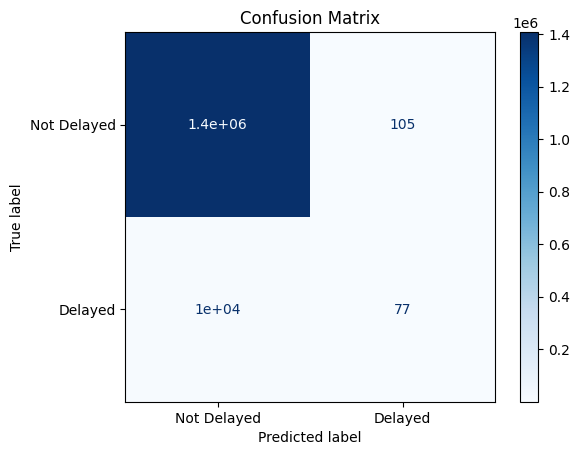

In [162]:
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Not Delayed", "Delayed"]
).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [163]:
cm

# XGBoost
# array([[1225409,  182135],
#        [   2756,    7707]])

# Random Forest
# array([[1407521,      23],
#        [  10375,      88]])

array([[1407439,     105],
       [  10386,      77]])

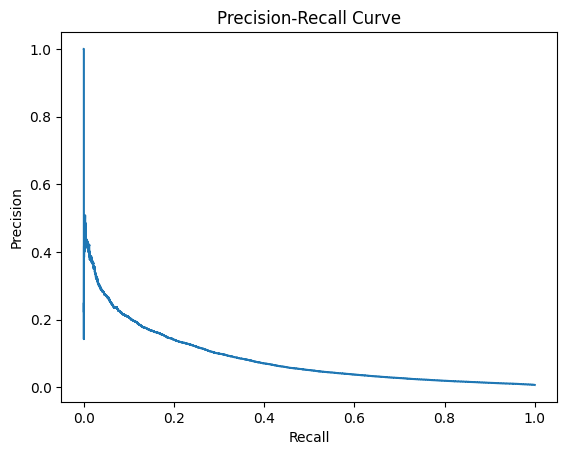

In [164]:
y_scores = model.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


In [165]:
from sklearn.metrics import roc_auc_score


y_pred_proba = model.best_estimator_.predict_proba(X_test)

ra_score = roc_auc_score(y_test, y_pred, average="macro", multi_class="ovr")

# xgboost
# 0.803598235336136

# random forest
# 0.5041971245888275

ra_score

0.5036423339808378

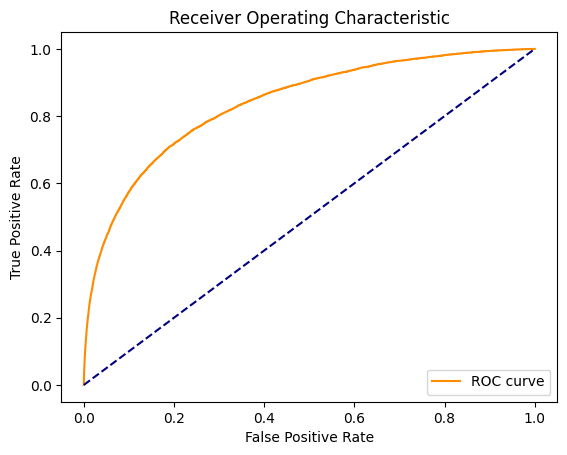

In [166]:
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

plt.figure()
plt.plot(fpr, tpr, color="darkorange", label="ROC curve")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

In [167]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

accuracy, precision, recall, f1

(0.9926015880034442,
 0.4230769230769231,
 0.0073592659848991685,
 0.014466885861906998)

In [ ]:
import altair as alt


metrics_scores = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred),
}

df_metrics = pd.DataFrame(list(metrics_scores.items()), columns=["Metric", "Score"])

alt.Chart(df_metrics).mark_bar().encode(
    y="Metric:N", x="Score:Q", color="Metric:N", text=alt.Text("Score:Q", format=".2f")
).properties(title="Evaluation Metrics", width=600, height=300).configure_axis(
    labelFontSize=12, titleFontSize=14
)